In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/synth2023/processed/patient_split.json
/kaggle/input/synth2023/processed/CT_slices/1BB205_axial_slice_111.npy
/kaggle/input/synth2023/processed/CT_slices/1BA201_axial_slice_128.npy
/kaggle/input/synth2023/processed/CT_slices/1BC014_axial_slice_086.npy
/kaggle/input/synth2023/processed/CT_slices/1BA001_axial_slice_125.npy
/kaggle/input/synth2023/processed/CT_slices/1BC041_axial_slice_074.npy
/kaggle/input/synth2023/processed/CT_slices/1BB041_axial_slice_072.npy
/kaggle/input/synth2023/processed/CT_slices/1BB007_axial_slice_078.npy
/kaggle/input/synth2023/processed/CT_slices/1BC083_axial_slice_085.npy
/kaggle/input/synth2023/processed/CT_slices/1BC064_axial_slice_091.npy
/kaggle/input/synth2023/processed/CT_slices/1BB051_axial_slice_053.npy
/kaggle/input/synth2023/processed/CT_slices/1BB011_axial_slice_091.npy
/kaggle/input/synth2023/processed/CT_slices/1BA185_axial_slice_094.npy
/kaggle/input/synth2023/processed/CT_slices/1BB062_axial_slice_119.npy
/kaggle/input/synth2023/

Using device: cuda
Train: 3780, Val: 540


Epoch 5 Val -> PSNR: 22.692, SSIM: 0.622, MAE_HU: 98.496


Epoch 10 Val -> PSNR: 16.536, SSIM: 0.254, MAE_HU: 83.143


Epoch 15 Val -> PSNR: 23.330, SSIM: 0.699, MAE_HU: 71.041


Epoch 20 Val -> PSNR: 23.816, SSIM: 0.737, MAE_HU: 63.725


Epoch 25 Val -> PSNR: 23.759, SSIM: 0.744, MAE_HU: 58.442


Epoch 30 Val -> PSNR: 23.514, SSIM: 0.738, MAE_HU: 51.021


Epoch 35 Val -> PSNR: 23.161, SSIM: 0.715, MAE_HU: 50.828


Epoch 40 Val -> PSNR: 23.880, SSIM: 0.765, MAE_HU: 50.985


Epoch 45 Val -> PSNR: 24.074, SSIM: 0.780, MAE_HU: 42.897


Epoch 50 Val -> PSNR: 23.260, SSIM: 0.758, MAE_HU: 47.245


Epoch 55 Val -> PSNR: 24.029, SSIM: 0.773, MAE_HU: 62.103


Epoch 60 Val -> PSNR: 23.623, SSIM: 0.769, MAE_HU: 42.966


Epoch 65 Val -> PSNR: 23.783, SSIM: 0.772, MAE_HU: 40.724


Epoch 70 Val -> PSNR: 24.004, SSIM: 0.781, MAE_HU: 41.844


Epoch 75 Val -> PSNR: 23.481, SSIM: 0.765, MAE_HU: 38.543


Epoch 80 Val -> PSNR: 23.678, SSIM: 0.762, MAE_HU: 44.413


Epoch 85 Val -> PSNR: 23.766, SSIM: 0.778, MAE_HU: 37.989


Epoch 90 Val -> PSNR: 23.824, SSIM: 0.779, MAE_HU: 35.357


Epoch 95 Val -> PSNR: 23.656, SSIM: 0.774, MAE_HU: 34.584


Epoch 100 Val -> PSNR: 24.028, SSIM: 0.792, MAE_HU: 32.382
Final Validation -> PSNR: 24.623, SSIM: 0.806
 Validation history saved to /kaggle/working/HU/val_history.csv
 Training history saved to /kaggle/working/HU/train_history.csv
Training completed!
Best 5 models (SSIM + MAE combo):
/kaggle/working/HU/netG_epoch100.pth -> Score=0.7599, SSIM=0.7922, MAE=32.38
/kaggle/working/HU/netG_epoch90.pth -> Score=0.7440, SSIM=0.7794, MAE=35.36
/kaggle/working/HU/netG_epoch85.pth -> Score=0.7405, SSIM=0.7785, MAE=37.99
/kaggle/working/HU/netG_epoch95.pth -> Score=0.7397, SSIM=0.7743, MAE=34.58
/kaggle/working/HU/netG_epoch70.pth -> Score=0.7391, SSIM=0.7809, MAE=41.84


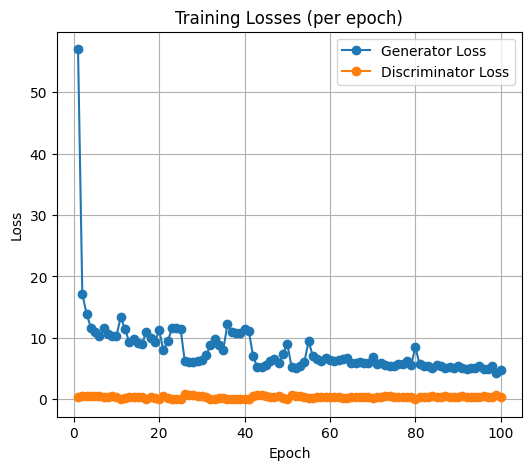

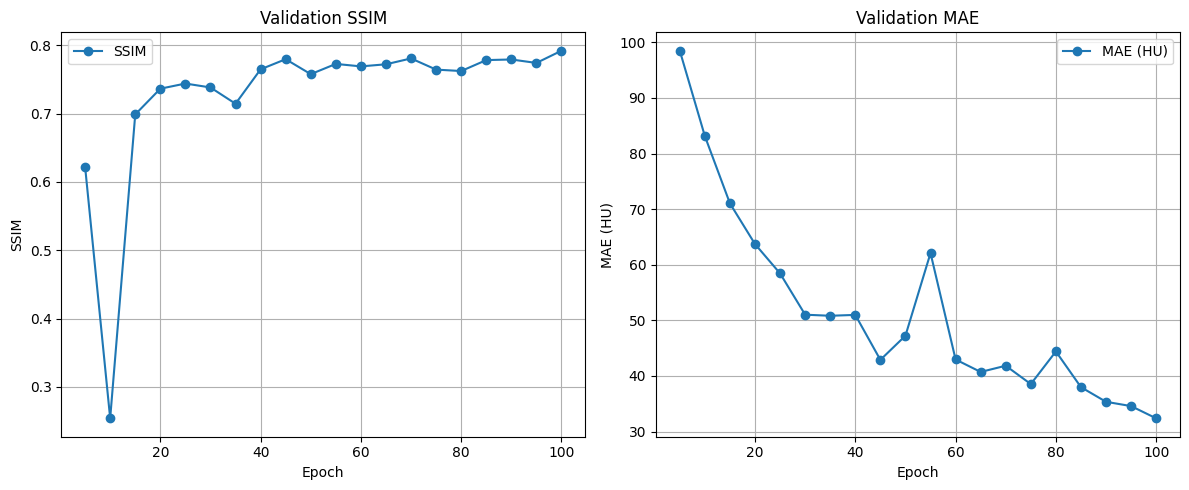

In [2]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as vutils
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F

# -------------------------
# Config
# -------------------------
class Config:
    data_root = "/kaggle/input/synth2023/processed"
    batch_size = 64
    num_epochs = 100
    lr = 2e-4
    beta1 = 0.5
    image_size = 256
    save_dir = "/kaggle/working/HU"
    validate_every = 5
    sample_grid_n = 4
    max_val_batches = 50

    # HU settings
    hu_min, hu_max = -1000, 2000
    lambda_L1 = 0.1   # HU-space L1 weight

cfg = Config()
os.makedirs(cfg.save_dir, exist_ok=True)

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
torch.backends.cudnn.benchmark = True

# -------------------------
# Helpers
# -------------------------
def denormalize_ct(ct_tensor):
    return 0.5 * (ct_tensor + 1.0) * (cfg.hu_max - cfg.hu_min) + cfg.hu_min

# -------------------------
# Dataset
# -------------------------
class MRICtDataset(Dataset):
    def __init__(self, split, split_json, mri_dir, ct_dir, image_size=256):
        with open(split_json, "r") as f:
            splits = json.load(f)
        if "files" not in splits:
            raise ValueError("split JSON doesn't contain 'files' key produced by preprocessing script.")
        if split not in splits["files"]:
            raise ValueError(f"split {split} not found in {split_json}")
        self.files = splits["files"][split]
        self.mri_dir, self.ct_dir = mri_dir, ct_dir
        self.image_size = image_size
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        mri_slice = np.load(os.path.join(self.mri_dir, fname)).astype(np.float32)
        ct_slice  = np.load(os.path.join(self.ct_dir, fname)).astype(np.float32)

        mri_slice = np.clip(mri_slice, -1.0, 1.0)
        ct_slice  = np.clip(ct_slice, -1.0, 1.0)

        if mri_slice.ndim == 2:
            mri_slice = np.expand_dims(mri_slice, -1)
        if ct_slice.ndim == 2:
            ct_slice = np.expand_dims(ct_slice, -1)

        mri = torch.from_numpy(mri_slice.transpose(2,0,1)).float()
        ct  = torch.from_numpy(ct_slice.transpose(2,0,1)).float()

        mri = F.interpolate(mri.unsqueeze(0), size=(self.image_size, self.image_size),
                            mode="bilinear", align_corners=False).squeeze(0)
        ct  = F.interpolate(ct.unsqueeze(0), size=(self.image_size, self.image_size),
                            mode="bilinear", align_corners=False).squeeze(0)

        return mri, ct

# -------------------------
# Load Data
# -------------------------
split_json = os.path.join(cfg.data_root, "patient_split.json")
mri_dir = os.path.join(cfg.data_root, "MRI_slices")
ct_dir  = os.path.join(cfg.data_root, "CT_slices")

train_dataset = MRICtDataset("train", split_json, mri_dir, ct_dir, cfg.image_size)
val_dataset   = MRICtDataset("val", split_json, mri_dir, ct_dir, cfg.image_size)

train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True,
                          num_workers=2, pin_memory=(device.type=="cuda"))
val_loader   = DataLoader(val_dataset, batch_size=min(8, cfg.batch_size), shuffle=False,
                          num_workers=2, pin_memory=(device.type=="cuda"))

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}")

# -------------------------
# Generator (U-Net)
# -------------------------
class UNetGenerator(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=64):
        super().__init__()
        def down_block(in_ch, out_ch, bn=True):
            layers = [nn.Conv2d(in_ch, out_ch, 4, 2, 1, bias=False)]
            if bn: layers.append(nn.BatchNorm2d(out_ch))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)

        def up_block(in_ch, out_ch, dropout=False):
            layers = [
                nn.ConvTranspose2d(in_ch, out_ch, 4, 2, 1, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            ]
            if dropout: layers.append(nn.Dropout(0.5))
            return nn.Sequential(*layers)

        self.down1 = down_block(in_channels, features, bn=False)
        self.down2 = down_block(features, features*2)
        self.down3 = down_block(features*2, features*4)
        self.down4 = down_block(features*4, features*8)
        self.down5 = down_block(features*8, features*8)
        self.down6 = down_block(features*8, features*8)
        self.down7 = down_block(features*8, features*8)
        self.down8 = down_block(features*8, features*8, bn=False)

        self.up1 = up_block(features*8, features*8, dropout=True)
        self.up2 = up_block(features*16, features*8, dropout=True)
        self.up3 = up_block(features*16, features*8, dropout=True)
        self.up4 = up_block(features*16, features*8)
        self.up5 = up_block(features*16, features*4)
        self.up6 = up_block(features*8, features*2)
        self.up7 = up_block(features*4, features)
        self.final = nn.Sequential(
            nn.ConvTranspose2d(features*2, out_channels, 4, 2, 1), nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x); d2 = self.down2(d1); d3 = self.down3(d2)
        d4 = self.down4(d3); d5 = self.down5(d4); d6 = self.down6(d5)
        d7 = self.down7(d6); bottleneck = self.down8(d7)
        u1 = self.up1(bottleneck)
        u2 = self.up2(torch.cat([u1, d7], 1))
        u3 = self.up3(torch.cat([u2, d6], 1))
        u4 = self.up4(torch.cat([u3, d5], 1))
        u5 = self.up5(torch.cat([u4, d4], 1))
        u6 = self.up6(torch.cat([u5, d3], 1))
        u7 = self.up7(torch.cat([u6, d2], 1))
        return self.final(torch.cat([u7, d1], 1))

# -------------------------
# Discriminator (PatchGAN)
# -------------------------
class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels=2, features=64):
        super().__init__()
        def block(in_ch, out_ch, stride=2, normalize=True):
            layers = [nn.Conv2d(in_ch, out_ch, 4, stride, 1, bias=False)]
            if normalize: layers.append(nn.BatchNorm2d(out_ch))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)

        self.model = nn.Sequential(
            block(in_channels, features, normalize=False),
            block(features, features*2),
            block(features*2, features*4),
            block(features*4, features*8, stride=1),
            nn.Conv2d(features*8, 1, 4, 1, 1)
        )

    def forward(self, x, y):
        inp = torch.cat([x, y], dim=1)
        return self.model(inp)

# -------------------------
# Training Setup
# -------------------------
netG = UNetGenerator().to(device)
netD = PatchDiscriminator().to(device)

criterion_GAN = nn.BCEWithLogitsLoss()
criterion_L1 = nn.L1Loss()

optimizer_G = optim.Adam(netG.parameters(), lr=cfg.lr, betas=(cfg.beta1, 0.999))
optimizer_D = optim.Adam(netD.parameters(), lr=cfg.lr, betas=(cfg.beta1, 0.999))

scaler = torch.amp.GradScaler("cuda")

# Resume if available
start_epoch = 0
resume_path = os.path.join(cfg.save_dir, "latest_checkpoint.pth")
if os.path.exists(resume_path):
    checkpoint = torch.load(resume_path, map_location=device)
    netG.load_state_dict(checkpoint["netG"])
    netD.load_state_dict(checkpoint["netD"])
    optimizer_G.load_state_dict(checkpoint["optG"])
    optimizer_D.load_state_dict(checkpoint["optD"])
    start_epoch = checkpoint.get("epoch", 0) + 1
    print(f"Resumed from epoch {start_epoch}")

# -------------------------
# Evaluation
# -------------------------
def evaluate_model(netG, loader, max_batches=None):
    netG.eval()
    psnr_vals, ssim_vals = [], []
    with torch.no_grad():
        for i, (mri, ct) in enumerate(loader):
            mri, ct = mri.to(device), ct.to(device)
            fake_ct = netG(mri)
            ct_np   = denormalize_ct(ct).squeeze(1).detach().cpu().numpy()
            fake_np = denormalize_ct(fake_ct).squeeze(1).detach().cpu().numpy()

            for gt, pred in zip(ct_np, fake_np):
                psnr_vals.append(peak_signal_noise_ratio(gt, pred, data_range=(cfg.hu_max - cfg.hu_min)))
                ssim_vals.append(structural_similarity(gt, pred, data_range=(cfg.hu_max - cfg.hu_min)))
            if (max_batches is not None) and (i+1 >= max_batches):
                break
    netG.train()
    return float(np.mean(psnr_vals)), float(np.mean(ssim_vals))

# -------------------------
# Save sample grid
# -------------------------
def save_sample_grid(netG, loader, path, n=4):
    netG.eval()
    imgs_list, saved = [], 0
    with torch.no_grad():
        for mri, ct in loader:
            mri, ct = mri.to(device), ct.to(device)
            fake = netG(mri)
            B = mri.shape[0]
            for b in range(B):
                imgs_list.extend([mri[b].cpu(), fake[b].cpu(), ct[b].cpu()])
                saved += 1
                if saved >= n: break
            if saved >= n: break
    if len(imgs_list) == 0: return None
    grid = torch.stack(imgs_list, dim=0)
    vutils.save_image(grid, path, nrow=3, normalize=True)
    netG.train()
    return grid

# -------------------------
# Training Loop
# -------------------------
best_models = []
val_history = []
train_history = {"epoch": [], "loss_G": [], "loss_D": []}

for epoch in range(start_epoch, cfg.num_epochs):
    netG.train(); netD.train()
    loop = tqdm(train_loader, leave=False)

    epoch_L1_hu, epoch_L1_norm, batch_count = 0.0, 0.0, 0
    epoch_loss_G, epoch_loss_D = 0.0, 0.0

    for mri, ct in loop:
        mri, ct = mri.to(device, non_blocking=True), ct.to(device, non_blocking=True)

        # ---------------- Train Generator ----------------
        optimizer_G.zero_grad()
        with torch.amp.autocast("cuda"):
            fake_ct = netG(mri)
            pred_fake = netD(mri, fake_ct)
            loss_GAN = criterion_GAN(pred_fake, torch.ones_like(pred_fake, device=device))

            fake_ct_hu = denormalize_ct(fake_ct)
            ct_hu      = denormalize_ct(ct)
            loss_L1_hu = criterion_L1(fake_ct_hu, ct_hu)
            loss_L1_norm = criterion_L1(fake_ct, ct)

            loss_G = loss_GAN + cfg.lambda_L1 * loss_L1_hu

        scaler.scale(loss_G).backward()
        scaler.step(optimizer_G)
        scaler.update()

        # ---------------- Train Discriminator ----------------
        optimizer_D.zero_grad()
        with torch.amp.autocast("cuda"):
            pred_real = netD(mri, ct)
            loss_real = criterion_GAN(pred_real, torch.ones_like(pred_real, device=device))
            pred_fake_det = netD(mri, fake_ct.detach())
            loss_fake = criterion_GAN(pred_fake_det, torch.zeros_like(pred_fake_det, device=device))
            loss_D = 0.5 * (loss_real + loss_fake)

        scaler.scale(loss_D).backward()
        scaler.step(optimizer_D)
        scaler.update()

        # Track running averages
        epoch_L1_hu   += loss_L1_hu.item()
        epoch_L1_norm += loss_L1_norm.item()
        epoch_loss_G  += loss_G.item()
        epoch_loss_D  += loss_D.item()
        batch_count   += 1

        loop.set_description(f"Epoch [{epoch+1}/{cfg.num_epochs}]")
        loop.set_postfix(loss_G=loss_G.item(), loss_D=loss_D.item(),
                         L1_HU=loss_L1_hu.item(), L1_norm=loss_L1_norm.item())

    # Store per-epoch averages
    train_history["epoch"].append(epoch+1)
    train_history["loss_G"].append(epoch_loss_G / batch_count)
    train_history["loss_D"].append(epoch_loss_D / batch_count)

    # ---------------- Validation & checkpointing ----------------
    if (epoch+1) % cfg.validate_every == 0:
        psnr, ssim = evaluate_model(netG, val_loader, max_batches=cfg.max_val_batches)
        mae_hu = epoch_L1_hu / max(1, batch_count)
        print(f"Epoch {epoch+1} Val -> PSNR: {psnr:.3f}, SSIM: {ssim:.3f}, MAE_HU: {mae_hu:.3f}")
        val_history.append({
            "epoch": epoch+1,
            "psnr": psnr,
            "ssim": ssim,
            "L1_HU": mae_hu,
            "L1_norm": epoch_L1_norm / max(1, batch_count)
        })

        sample_path = os.path.join(cfg.save_dir, f"epoch_{epoch+1}_samples.png")
        save_sample_grid(netG, val_loader, sample_path, n=cfg.sample_grid_n)
        model_path = os.path.join(cfg.save_dir, f"netG_epoch{epoch+1}.pth")
        torch.save(netG.state_dict(), model_path)

        # --- Combined score: prioritize SSIM, penalize high MAE ---
        score = ssim - 0.001 * mae_hu
        best_models.append((score, ssim, mae_hu, model_path))
        best_models = sorted(best_models, key=lambda x: x[0], reverse=True)[:5]

        torch.save({"epoch": epoch, "netG": netG.state_dict(), "netD": netD.state_dict(),
                    "optG": optimizer_G.state_dict(), "optD": optimizer_D.state_dict()},
                   os.path.join(cfg.save_dir, "latest_checkpoint.pth"))

# -------------------------
# Final Validation
# -------------------------
psnr_final, ssim_final = evaluate_model(netG, val_loader, max_batches=None)
print(f"Final Validation -> PSNR: {psnr_final:.3f}, SSIM: {ssim_final:.3f}")

# Save validation history
val_csv = os.path.join(cfg.save_dir, "val_history.csv")
pd.DataFrame(val_history).to_csv(val_csv, index=False)
print(f" Validation history saved to {val_csv}")

# Save training history
train_csv = os.path.join(cfg.save_dir, "train_history.csv")
pd.DataFrame(train_history).to_csv(train_csv, index=False)
print(f" Training history saved to {train_csv}")

print("Training completed!")

# -------------------------
# Print Best Models
# -------------------------
print("Best 5 models (SSIM + MAE combo):")
for score, ssim, mae, path in best_models:
    print(f"{path} -> Score={score:.4f}, SSIM={ssim:.4f}, MAE={mae:.2f}")

# -------------------------
# Plot G/D losses
# -------------------------
plt.figure(figsize=(6,5))
plt.plot(train_history["epoch"], train_history["loss_G"], marker="o", label="Generator Loss")
plt.plot(train_history["epoch"], train_history["loss_D"], marker="o", label="Discriminator Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training Losses (per epoch)")
plt.legend(); plt.grid()
plt.savefig(os.path.join(cfg.save_dir, "train_losses.png"))
plt.show()
plt.close()

# -------------------------
# Plot Validation SSIM & MAE
# -------------------------
if len(val_history) > 0:
    val_df = pd.DataFrame(val_history)

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(val_df["epoch"], val_df["ssim"], marker="o", label="SSIM")
    plt.xlabel("Epoch"); plt.ylabel("SSIM"); plt.title("Validation SSIM")
    plt.grid(); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(val_df["epoch"], val_df["L1_HU"], marker="o", label="MAE (HU)")
    plt.xlabel("Epoch"); plt.ylabel("MAE (HU)"); plt.title("Validation MAE")
    plt.grid(); plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(cfg.save_dir, "val_metrics.png"))
    plt.show()
    plt.close()
